In [1]:
import hax
hax.__version__

hax.init(experiment='XENON1T',
         pax_version_policy='loose',
         sc_api_key='ssn1sslkvdhittoywjk88w9cmbxf4fmprn68r8hm',
         force_reload=False,
         raw_data_access_mode = 'local',
         raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1',''],
         minitree_paths= ['/project2/lgrandi/zhut/minitrees/pax_v6.10.1',
                          '/project2/lgrandi/zhut/minitrees/pax_v6.10.0',
                          '/project2/lgrandi/xenon1t/minitrees/pax_v6.10.0',
                          '/project2/lgrandi/xenon1t/minitrees/latest'],
         use_rundb=True,
         make_minitree=False,
         minitree_caching=True,)

In [33]:
os.listdir('/project/lgrandi/xenon1t/raw_for_waveforms/170818_0311')

['XENON1T-12200-000004000-000004999-000001000.zip']

In [42]:
df_ms_peaks.to_pickle('wf_samples.pkl')

In [2]:
%run '/home/zhut/Beta_Beta/Calibration_MS/Initialize_tianyu.ipynb'

In [8]:
from MultipleS2Peaks_PUpdate import MultipleS2Corrections, MultipleS2Peaks
mc, mp = MultipleS2Corrections(), MultipleS2Peaks()

In [27]:
run_names = [f[:11] for f in os.listdir(hax.config['minitree_paths'][0]) if 'MultipleS2Peaks.root' in f]
#run_names = ['171005_0423']


In [5]:
df_ms_peaks = hax.minitrees.load(run_names, [MultipleS2Peaks])

In [9]:
import pickle
with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix_pattern = pickle.load(f)
    
with open('/project2/lgrandi/zhut/s2_width_classifier_gmix_v6.10.0.pkl', 'rb') as f:
    gmix_width = pickle.load(f)

df_ms_peaks['not_interaction_pattern'] = False
mask = df_ms_peaks.goodness_of_fit_tpf > 0
X = np.log10(df_ms_peaks.loc[mask, ['area', 'goodness_of_fit_tpf', 's2']])
df_ms_peaks.loc[mask, 'not_interaction_pattern'] = np.array(gmix_pattern.predict(X), bool)

df_ms_peaks['not_interaction_width'] = False
mask = (df_ms_peaks.range_50p_area > 0) & (df_ms_peaks.z < 0)
df_ms_peaks.loc[mask, 'width_normed'] = df_ms_peaks.loc[mask, 'range_50p_area'] / mp.s2_width_model(df_ms_peaks.loc[mask, 'z'])
X = np.column_stack([np.log10(df_ms_peaks.loc[mask, 'area']), df_ms_peaks.loc[mask, 'width_normed']])
df_ms_peaks.loc[mask, 'not_interaction_width'] = np.array(gmix_width.predict(X), bool)

In [22]:
from sklearn.mixture import GaussianMixture
gmix_pattern_1 = GaussianMixture(n_components=2, covariance_type='full', max_iter=400, n_init=30)
X = np.log10(d.loc[:,['area', 'goodness_of_fit_tpf', 's1']])
gmix_pattern_1 = gmix_pattern_1.fit(X)
d.loc[:,'not_interaction_pattern'] = np.array(gmix_pattern_1.predict(X), bool)

Index(['area', 'area_fraction_top', 'carea_nn', 'carea_tpf', 'center_time',
       'drift_time', 'event_number', 'goodness_of_fit_nn',
       'goodness_of_fit_tpf', 'index_of_maximum', 'not_interaction',
       'not_interaction_depth', 'not_interaction_pattern',
       'not_interaction_width', 'range_50p_area', 'run_number', 's1',
       's1_xyz_correction_nn_fdc_3d', 's1_xyz_correction_tpf_fdc_2d', 's2',
       's2_lifetime_correction', 's2_xy_nn_correction_tot',
       's2_xy_tpf_correction_tot', 'weighted_s1_xyz_correction_nn_fdc_3d',
       'weighted_s1_xyz_correction_tpf_fdc_2d', 'x_nn', 'x_tpf', 'y_nn',
       'y_tpf', 'z', 'width_normed'],
      dtype='object')

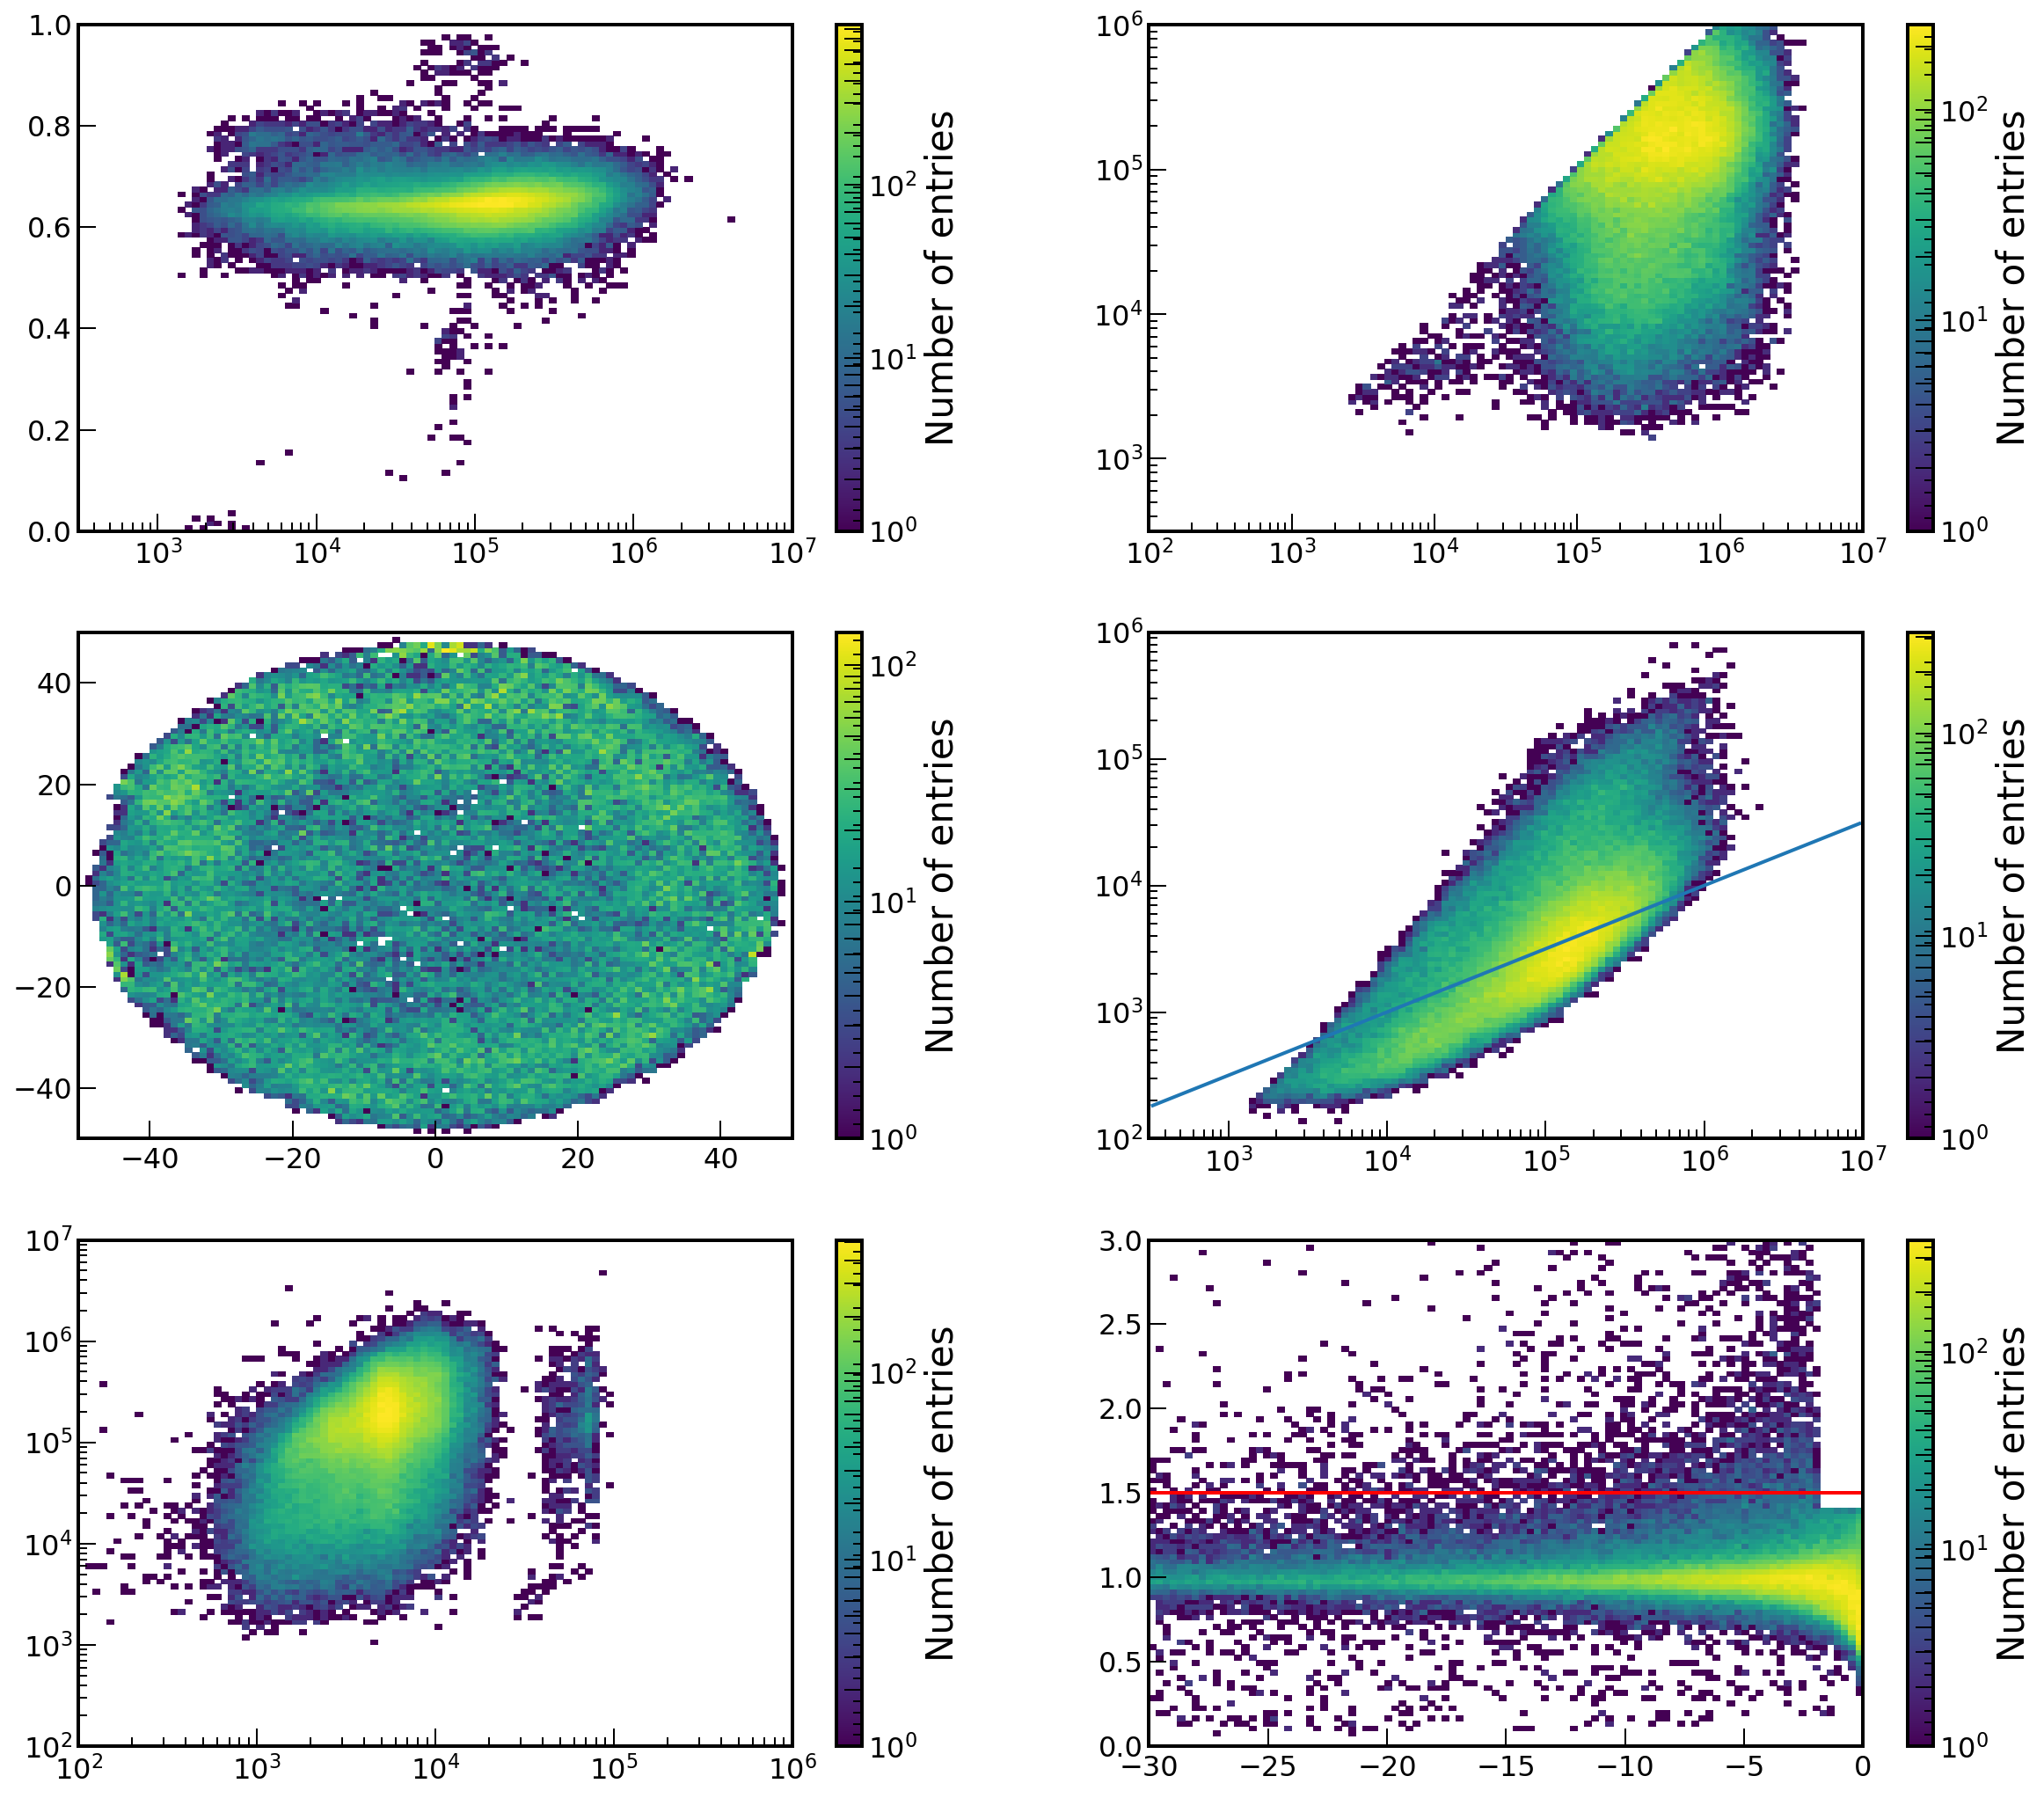

In [26]:
d = df_ms_peaks[(df_ms_peaks.z>-100) 
                & (df_ms_peaks.z<0) 
                & (df_ms_peaks.area>500) 
                & (df_ms_peaks.area<df_ms_peaks.s2)
                & (~df_ms_peaks.not_interaction_pattern) #(df_ms_peaks.goodness_of_fit_tpf<10*df_ms_peaks.area**0.5)
                & ((df_ms_peaks.width_normed<1.4) | (df_ms_peaks.z<-2))
               ]

s2_width_model = lambda z: np.sqrt(np.square(229.58)-2*29.35*z/.1335**3)*1.349    

with initiate_plot(20, 18):
    ax = fig.add_subplot(321)
    argx, argy = 'area', 'area_fraction_top'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.logspace(2.5, 7, 101), np.linspace(0, 1, 101)]
               )
    mh.plot(log_scale=True)
    plt.xscale('log')
    
    ax = fig.add_subplot(322)
    argx, argy = 's2', 'area'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.logspace(2, 7, 101), np.logspace(2.5, 6, 101)]
               )
    mh.plot(log_scale=True)
    plt.xscale('log'); plt.yscale('log')
    
    ax = fig.add_subplot(323)
    argx, argy = 'x_tpf', 'y_tpf'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.linspace(-50, 50, 101), np.linspace(-50, 50, 101)]
               )
    mh.plot(log_scale=True)
    
    ax = fig.add_subplot(324)
    argx, argy = 'area', 'goodness_of_fit_tpf'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.logspace(2.5, 7, 101), np.logspace(2, 6, 101)]
               )
    mh.plot(log_scale=True)
    x = mh.bin_centers(axis=0)
    plt.plot(x, 10*x**0.5)
    plt.xscale('log'); plt.yscale('log')
    

    ax = fig.add_subplot(325)
    argx, argy = 's1', 'carea_nn'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.logspace(2, 6, 101), np.logspace(2, 7, 101)]
               )
    mh.plot(log_scale=True)
    plt.xscale('log'); plt.yscale('log')
    
    ax = fig.add_subplot(326)
    argx, argy = 'z', 'width_normed'
    mh = Histdd(d.eval(argx), d.eval(argy),
                bins=[np.linspace(-30, 0, 101), np.linspace(0, 3, 101)]
               )
    mh.plot(log_scale=True)
    plt.axhline(1.5, color='r')


In [11]:
df_ms_corrections = hax.minitrees.load(run_names, ['Fundamentals', 'Corrections', MultipleS2Corrections])

(((run_number>17580) & (run_number<=17820)) | (run_number<=16639) | ((0.0137*(cs1/.1426 + cs2_bottom/11.55) < 56.5) | (0.0137*(cs1/.1426 + cs2_bottom/11.55) > 72.))) & ((largest_other_s2 > 200) | ((cs1<252) & (log(cs2_bottom/cs1)/log(10) > 0.466119*exp(-cs1/47.9903) + 1.31033 -0.000314047*cs1 + 1.33977/cs1)) | ((cs1<20) & (log(cs2_bottom/cs1)/log(10) < 1.08159)) | (cs1>3000) | ((250<cs1) & (cs1<375) & (log(cs2_bottom/cs1)/log(10) > 0.822161*exp(-(cs1-207.702)/343.275) + 0.515139)) | ((20<=cs1) & (log(cs2_bottom/cs1)/log(10) < 1.21239 + -0.0016025*cs1 + -1.97495/cs1)) | (s2<200) | ((cs1<80) & (run_number<=16639)) | ((cs1<500) & (r_3d_nn>47.9)) | ((cs1>=375) & (log(cs2_bottom/cs1)/log(10) > 1.02015))) & (((0.0137*(cs1/(z_3d_nn*0.000092 + 0.14628) + cs2_bottom/(-0.017*z_3d_nn + 10.628)) < 2457.83*(1 - 4*0.01)) | (0.0137*(cs1/(z_3d_nn*0.000092 + 0.14628) + cs2_bottom/(-0.017*z_3d_nn + 10.628)) > 2457.83*(1 + 4*0.01)))) selection: 21757 rows removed (85.06% passed)


In [12]:
g1_p10=0.1440; g2_p10=11.23
w=13.7e-3
energy=[32.147, 41.543,
        163.930, 236.14,
        1120.287, 1173.240, 1238.110, 1332.508, 1460.822,
        1764.494, 1847.420, 2118.55, 2204.21, 2614.552]
labels=['Kr83m', 'Kr83m',
        'Xe131', 'Xe129',
        'Bi214', 'Co60', 'Bi214', 'Co60', 'K40',
        'Bi214', 'Bi214', 'Bi214', 'Bi214', 'Tl208']


In [13]:
from lax.lichens.sciencerun1 import S2SingleScatter
s2s = S2SingleScatter()

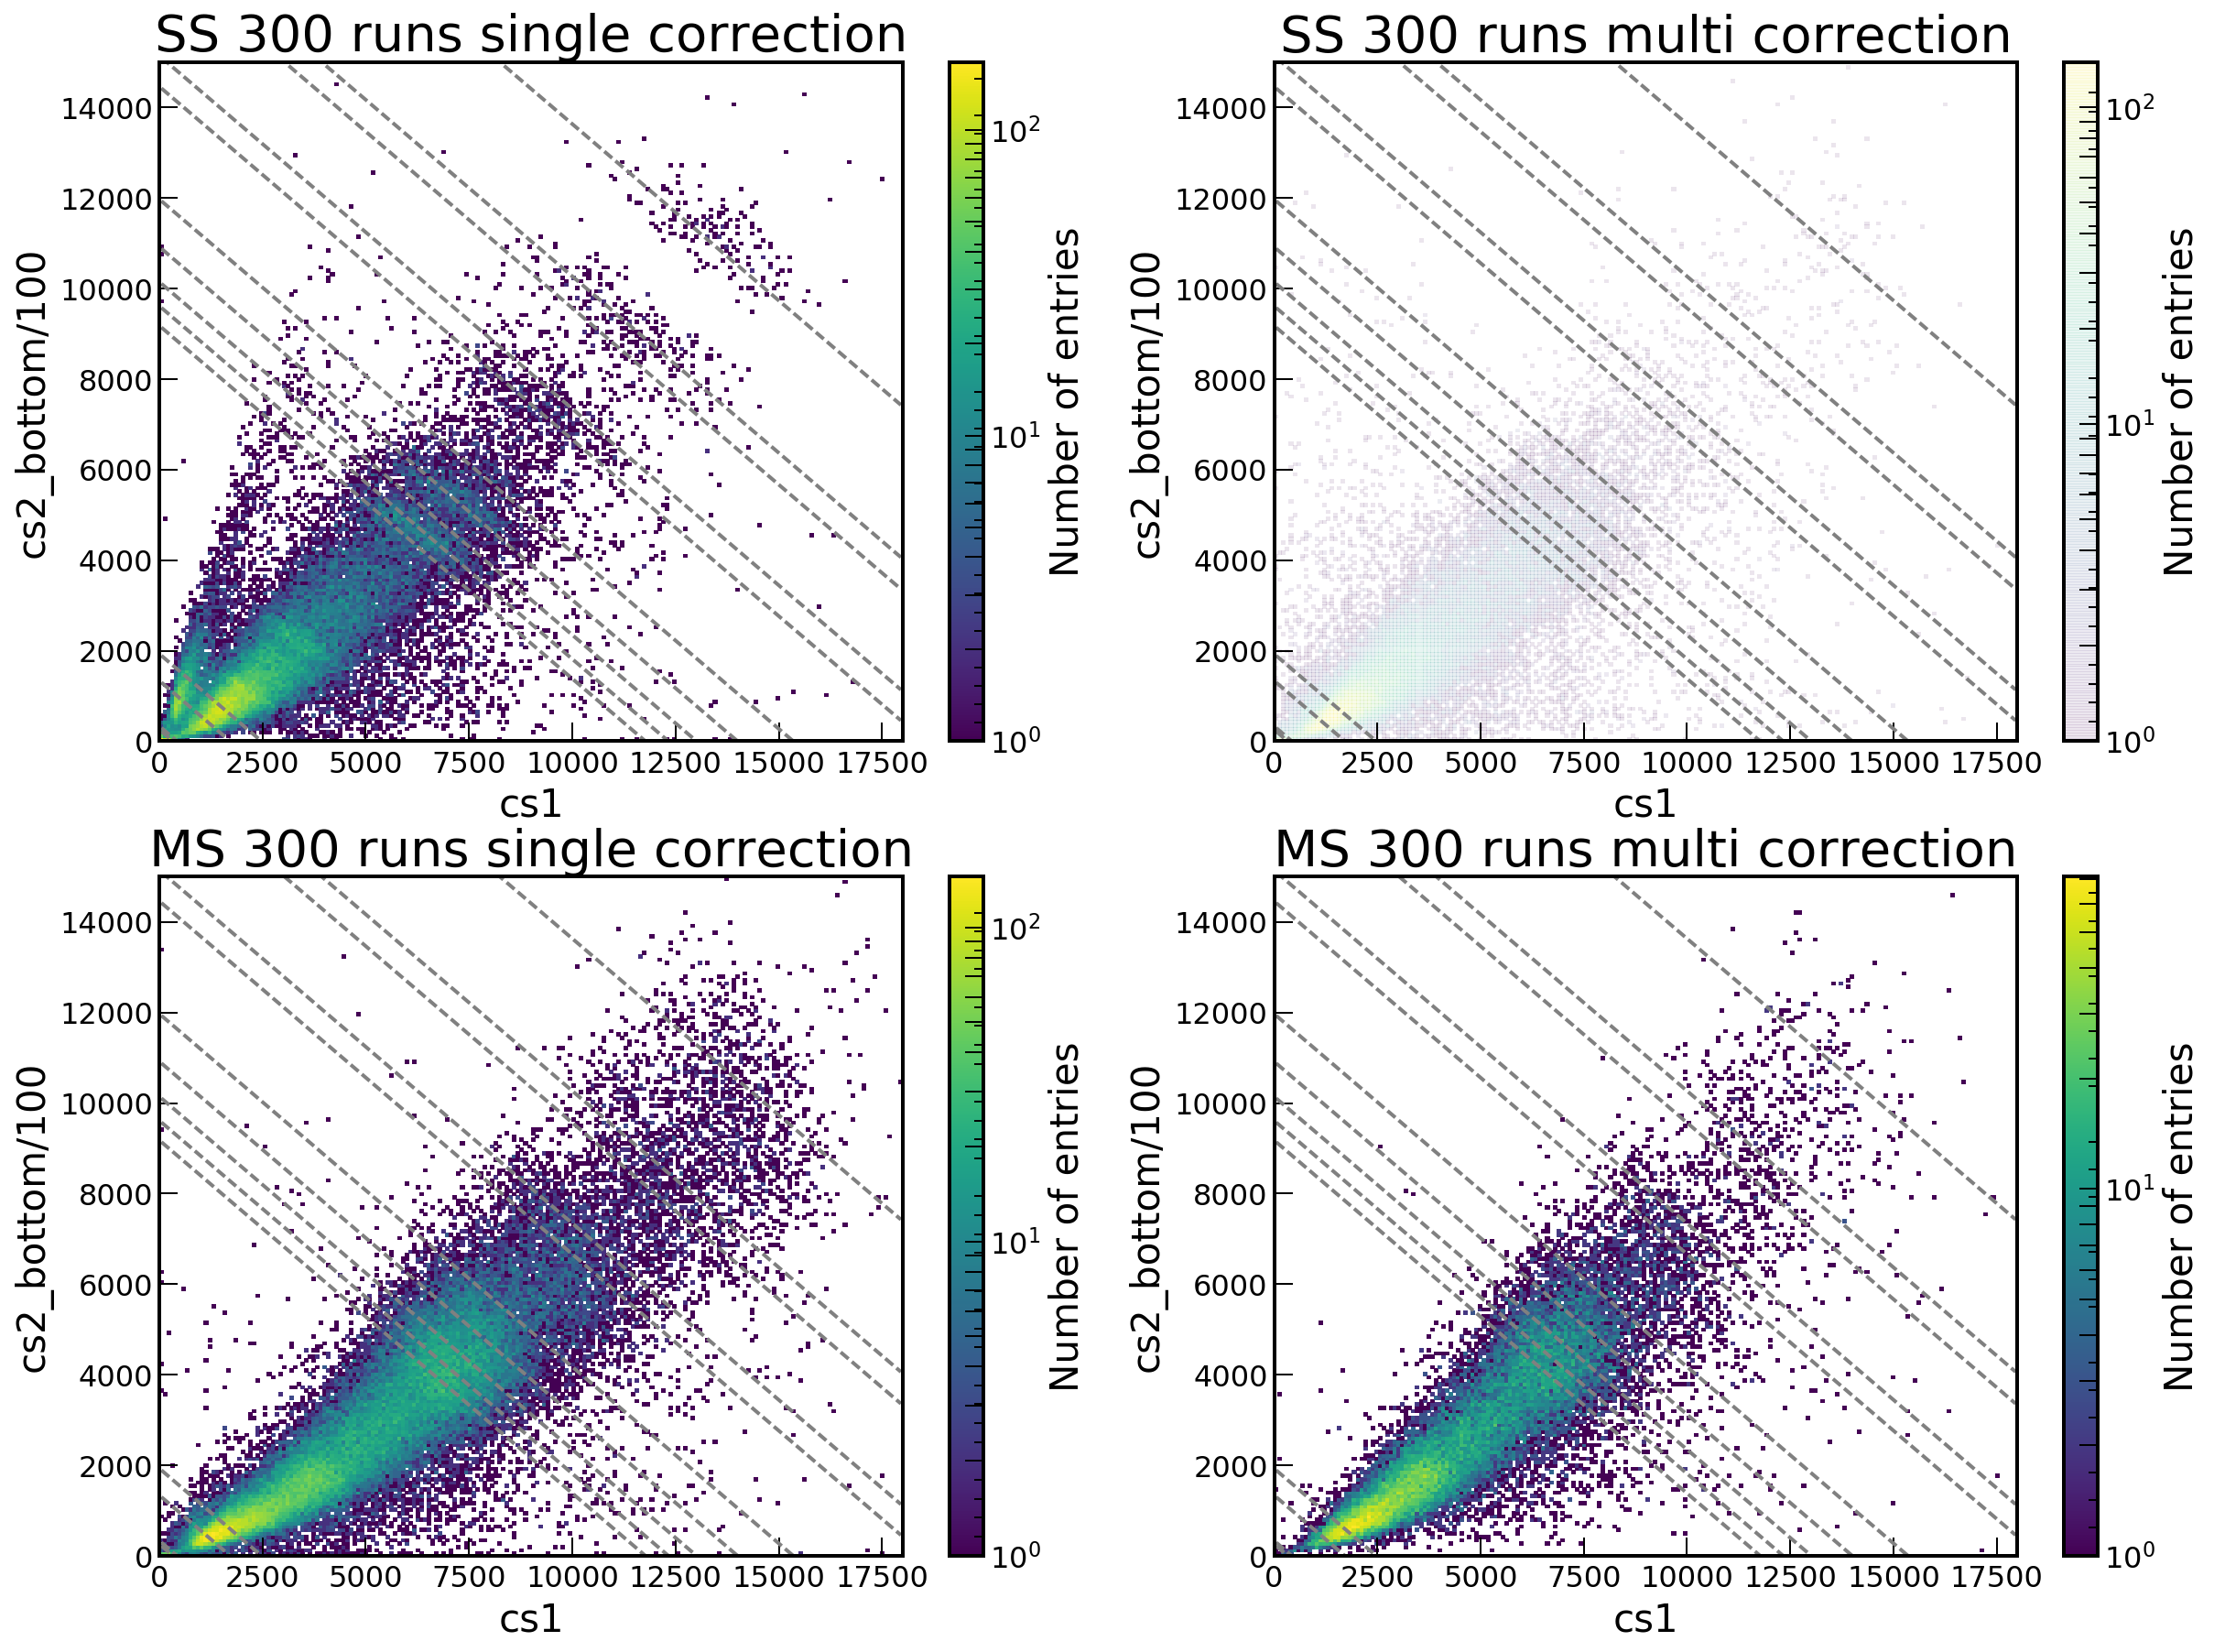

In [14]:
df_ms_corrections = s2s.process(df_ms_corrections)
df_ms_corrections['CutS2MultipleScatter'] = df_ms_corrections.n_multi_peak==2

with initiate_plot(20, 15):
    dataframes = ['df_ms_corrections[df_ms_corrections.CutS2SingleScatter]',
                  'df_ms_corrections[df_ms_corrections.CutS2SingleScatter]', 
                  'df_ms_corrections[~df_ms_corrections.CutS2SingleScatter]',
                  'df_ms_corrections[df_ms_corrections.CutS2MultipleScatter]']
    argx = ['{df}.cs1', '{df}.cs1', '{df}.cs1_multi_peak', '{df}.cs1_multi_peak']
    argy = ['{df}.cs2_bottom/100', '{df}.cs2b_multi_peak/100', '{df}.cs2b_multi_peak/100', '{df}.cs2b_multi_peak/100']
    
    titles = ['SS 300 runs single correction', 'SS 300 runs multi correction',
              'MS 300 runs single correction', 'MS 300 runs multi correction']
    alpha = [1, 0.1, 1, 1]
    for ix in range(4):
        ax = fig.add_subplot(221+ix)
        mh = Histdd(eval(argx[ix].format(df=dataframes[ix])),
                    eval(argy[ix].format(df=dataframes[ix])),
                    axis_names=['cs1', 'cs2_bottom/100'],
                    bins=[np.linspace(1e1, 1.8e4, 201), np.linspace(1e1, 1.5e4, 201)]
                   )
        mh.plot(log_scale=True, cmap=plt.get_cmap('viridis'), alpha = alpha[ix])
        plt_config(title=titles[ix])
        [plt.plot(mh.bin_centers(axis=0), (E/w-mh.bin_centers(axis=0)/g1_p10)*g2_p10/100, 'grey', ls='--') for E in energy]
